<a href="https://colab.research.google.com/github/Paula-Bautista/Proyecto-Final/blob/main/Copia_de_Untitled13.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
plt.rcParams['figure.figsize'] = (6, 6)
plt.rcParams['image.cmap'] = 'viridis'

In [2]:
N = 50
G = nx.grid_2d_graph(N, N)
posiciones = {(i, j): (i, j) for i, j in G.nodes()}


In [3]:
# Parámetros biológicamente inspirados
E_c = 4          # Umbral de disparo (análogo a V_threshold)
mu_normal = 1.0   # Mielina normal
mu_alta = 2.0     # Mielinización aumentada
alpha = 0.01      # Degeneración sináptica

# Energía inicial aleatoria
E = np.random.randint(0, E_c, size=(N, N))

# Matriz de conectividad (1 = activa)
C = np.ones((N, N))



    Realiza un paso de actualización del sistema:
    - verifica neuronas que superan el umbral
    - distribuye energía entre vecinas
    - retorna: matriz modificada y tamaño de la avalancha

In [4]:
def paso(E, C, mu):
    disparos = E >= E_c
    tam_avalancha = disparos.sum()
    if tam_avalancha == 0:
        return E, C, 0
    nuevos_E = E.copy()
    for i in range(N):
        for j in range(N):
            if disparos[i, j]:
                # Energía a repartir
                energia = E[i, j]
                vecinos = []
                # Vecinos válidos
                for di, dj in [(-1,0),(1,0),(0,-1),(0,1)]:
                    ni, nj = i+di, j+dj
                    if 0 <= ni < N and 0 <= nj < N:
                        vecinos.append((ni, nj))
                if len(vecinos) > 0:
                    transferencia = energia / len(vecinos)
                    for ni, nj in vecinos:
                        nuevos_E[ni, nj] += mu * C[i, j] * transferencia
                nuevos_E[i, j] = 0  # Se reinicia tras disparo
    return nuevos_E, C, tam_avalancha


Simulación general

In [5]:
def simular(mu, alpha, pasos=3000):
    E = np.random.randint(0, E_c, size=(N, N)).astype(float) # Initialize E as float
    C = np.ones((N, N))
    avalanchas = []

    for t in range(pasos):
        C *= (1 - alpha)# Degeneración progresiva
        E += np.random.random((N, N)) * 0.2# Aplicación de un pequeño input externo
        E, C, size = paso(E, C, mu)  # Actualización
        avalanchas.append(size)

    return np.array(avalanchas), E

In [6]:
ava_saludable, E_fin_sano = simular(mu=mu_normal, alpha=0)
ava_deg, E_fin_deg = simular(mu=mu_normal, alpha=alpha)
ava_mielina, E_fin_mielina = simular(mu=mu_alta, alpha=alpha)

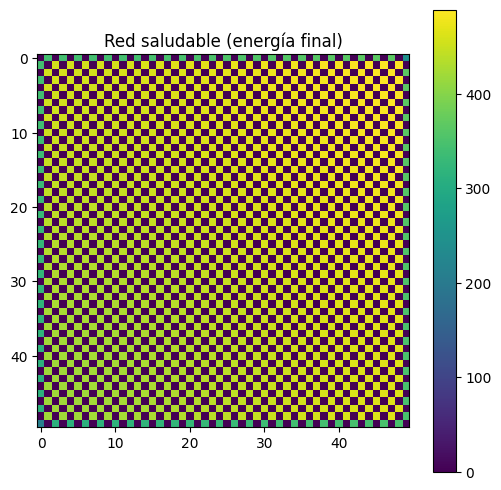

In [7]:
plt.imshow(E_fin_sano)
plt.title("Red saludable (energía final)")
plt.colorbar()
plt.show()


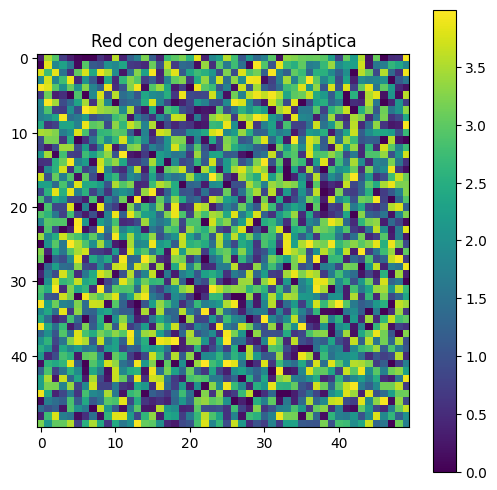

In [8]:
plt.imshow(E_fin_deg)
plt.title("Red con degeneración sináptica")
plt.colorbar()
plt.show()


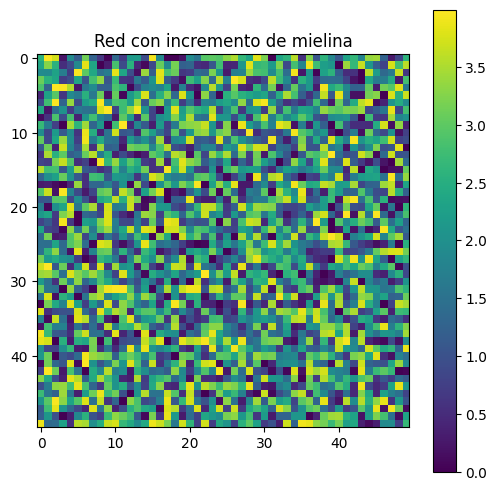

In [9]:
plt.imshow(E_fin_mielina)
plt.title("Red con incremento de mielina")
plt.colorbar()
plt.show()


Comparación temporal del tamaño de las avalanchas

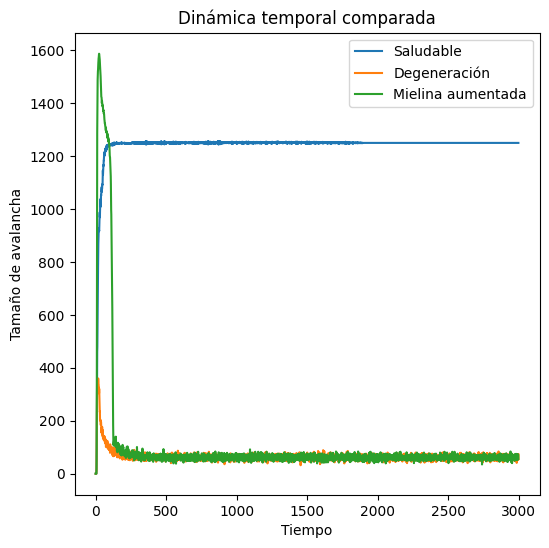

In [10]:
plt.plot(ava_saludable, label='Saludable')
plt.plot(ava_deg, label='Degeneración')
plt.plot(ava_mielina, label='Mielina aumentada')
plt.xlabel("Tiempo")
plt.ylabel("Tamaño de avalancha")
plt.title("Dinámica temporal comparada")
plt.legend()
plt.show()


Distribución de avalanchas (ley de potencias)

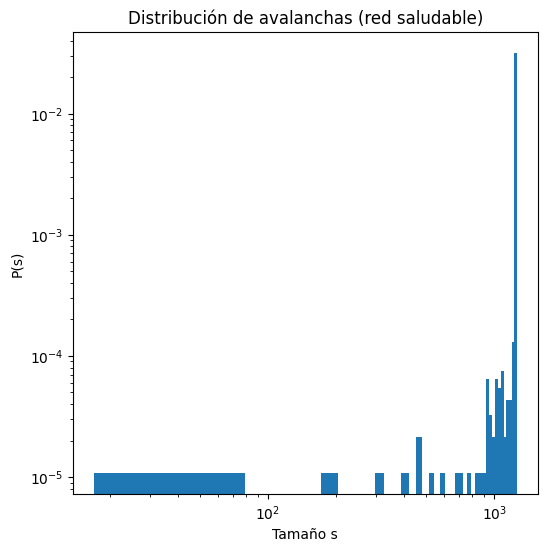

In [11]:
plt.hist(ava_saludable[ava_saludable>0], bins=40, density=True)
plt.title("Distribución de avalanchas (red saludable)")
plt.xlabel("Tamaño s")
plt.ylabel("P(s)")
plt.yscale("log")
plt.xscale("log")
plt.show()
